In [1]:
import argparse
import torch
from models.autoencoder import MNIST_AutoEncoder
from data.dataloader import get_dataloader_experiment
from utils.math import cosine_similarity, centroid_point, parametric_line_equations, distance_between_two_points
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
model_path = 'data/model_weights/mnist_autoencoder_full.pth'
generated_images = 'data/train_data/adv_mnist/'
real_images = 'data/train_data/mnist/'
number_of_samples = 1000
n_neighbours = 10

In [3]:
model = torch.load(model_path, map_location=torch.device('cpu'))

In [4]:
def construct_dataset(generated_image_path, real_image_path, autoencoder, plot_images=False):
    dataloader = get_dataloader_experiment(
        real_image_path, generated_image_path)
    data = []
    for img, label, img_name in dataloader:
        encoded, decoded = autoencoder(img)
        if plot_images:
            plt.imshow(img.detach().squeeze().numpy())
            plt.show()
            plt.imshow(decoded.detach().squeeze().numpy())
            plt.show()
        data.append((
            img_name[0],
            label[0],
            encoded.data.squeeze().view(-1).data.cpu().numpy()
        ))
    return data

In [5]:
data = construct_dataset(generated_images, real_images, model)

In [6]:
def neightbours_search(data, target, n, cosine=True):
    neighbours = []
    for idx in range(len(data)):
        if data[idx][1] == 'real':
            if cosine:
                neighbours.append((
                    data[idx][0],
                    cosine_similarity(target[2], data[idx][2]),
                    idx
                ))
            else:
                neighbours.append((
                    data[idx][0],
                    euclidean_distance(target[2], data[idx][2]),
                    idx
                ))
    neighbours = sorted(
        neighbours, key=lambda x: x[1], reverse=cosine
    )[:(n + 1)]
    neighbours_values = []
    for neightbour in neighbours[1:]:
        neighbours_values.append(data[neightbour[2]])
    return neighbours_values


def distance_comparison_to_distribution(data, on_fake=True):
    if on_fake:
        target_idx = np.random.randint(0, number_of_samples * 10 - 1)
    else:
        target_idx = np.random.randint(
            number_of_samples * 10,
            number_of_samples * 10 + number_of_samples * 10)
    target = data[target_idx]

    # neighbours of a target
    neighbour_point_target = neightbours_search(
        data, target, n_neighbours, cosine=True)
    centroid_point_coordinates = centroid_point(
        [x[2] for x in neighbour_point_target])
    position_vector, normal_vector = parametric_line_equations(
        centroid_point_coordinates, target[2])
    target_centroid_distance = distance_between_two_points(
        centroid_point_coordinates, target[2])
    # neighbours of a neighbours
    distances_mx_i = []
    distances_mx_i_normalized = []
    for n, i in enumerate(neighbour_point_target):
        neighbour_point_neighbour = neightbours_search(
            data, i, n_neighbours, cosine=True)
        centroid_point_coordinates = centroid_point(
            [x[2] for x in neighbour_point_neighbour])
        position_vector, normal_vector = parametric_line_equations(
            centroid_point_coordinates, i[2])
        i_centroid_distance = distance_between_two_points(
            centroid_point_coordinates, i[2])
        distances_mx_i.append(i_centroid_distance)
        distances_mx_i_normalized.append(
            i_centroid_distance / target_centroid_distance)
    return target_centroid_distance, distances_mx_i, distances_mx_i_normalized

In [7]:
distances_normalized_fake = np.zeros((
    number_of_samples, n_neighbours
))
distances_normalized_real = np.zeros((
    number_of_samples, n_neighbours
))
for i in tqdm(range(number_of_samples)):
    _, orig_f, res_f = distance_comparison_to_distribution(
            data
    )
    _, orig_r, res_r = distance_comparison_to_distribution(
        data, False
    )
    distances_normalized_fake[i] = res_f
    distances_normalized_real[i] = res_r
print('Done!')

100%|██████████| 1000/1000 [57:49<00:00,  3.47s/it]

Done!


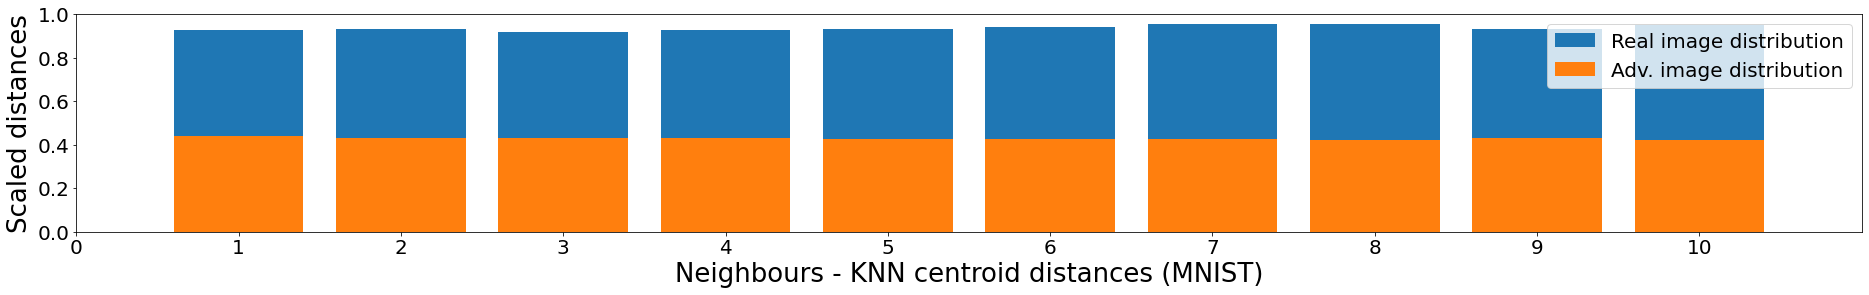

In [10]:
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.figure(figsize=(32, 4))
plt.ylim(0, 1)
plt.xlim(0, n_neighbours + 1)
plt.bar(
        list(range(1, n_neighbours + 1)),
        distances_normalized_real.mean(axis=0),
        label='Real image distribution'
)
plt.bar(
        list(range(1, n_neighbours + 1)),
        distances_normalized_fake.mean(axis=0),
        label='Adv. image distribution'
    )
plt.legend(loc=1, prop={'size': 20})
plt.xticks(list(range(n_neighbours + 1)))
plt.xlabel(f'Neighbours - KNN centroid distances (MNIST)', fontsize=26)
plt.ylabel('Scaled distances', fontsize=26)
plt.savefig('mnist_distribution.png')
plt.show()